# Bike-Share trip analysis



In this study, we scrutinize the data from the past year on Divvy Bikeshare trips in Chicago. Our primary business query is to identify the key differences in how casual users and paying members use Divvy bikes. Following this analysis, we aim to formulate business strategies to transition casual users into paying subscribers.

The data is available publicly at: https://divvy-tripdata.s3.amazonaws.com/index.html

It has some major limitations: there is no way to group the trips by user, since the data is completely anonimized. There is also no demographic data, which would have allowed us to see if the trip-taker lives in the area or is visiting short term. 

In [1]:
import os
import pandas as pd
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy
from cartopy.io.img_tiles import OSM
from sklearn.cluster import KMeans,OPTICS
import csv
import zipfile
import numpy as np
import glob
import pickle
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import warnings
from datetime import datetime, timedelta, date

warnings.filterwarnings('ignore')

extract_path='data/'
zip_dir='data/originals/'   



## Data Preparation and Cleaning
Files are extracted for .zip files in data/originals folder, then processed, and combined into a single pickle file.

### Cleaning 
- Time columns are converted to pandas datetime datatype.
- Cases where start date is after end date are fixed by swapping the two
- Extreme outlier cases where the ride duration is >1 day are likely incorrectly logged or are extreme outliers, are removed
- "instant trips" (<30 seconds) are removed, these seem to be mistaken unlocks where bikes are returned immediately

### Processing
- The original data comes with GPS coordinates of start and end of each trip. For our basic analysis we make use of these by using them to calculate the trip distance. After the calculation the coordinate columns are dropped.
- Ride duration is calculated as timedelta
- Day of the week is determined from the start date
- Speed is calculated from the distance and trip duration


In [2]:
# This function calculates the distance between two geographical points using haversine formula
def calc_distance(start_lat,start_lng,end_lat,end_lng):
    start=(start_lat,start_lng)
    end=(end_lat,end_lng)
    dist=haversine(start,end,unit=Unit.MILES)
    return dist

def process(df):
    df['started_at']=pd.to_datetime(df['started_at'])
    df['ended_at']=pd.to_datetime(df['ended_at'])
    df['ride_duration']=abs(df['ended_at']-df['started_at'])
    df['day_of_week']=df['started_at'].dt.dayofweek
    df['distance']=df.apply(lambda row: calc_distance(row["start_lat"], row["start_lng"], row["end_lat"], row["end_lng"]), axis=1)
    df['distance']=df['distance'].round(2)
    df['speed']=df['distance']/df['ride_duration'].dt.total_seconds()*3600
    df['speed']=df['speed'].round(2)
    df['speed']=df['speed'].replace(np.inf,np.nan)
    df=df.drop(columns=['start_lat','start_lng','end_lat','end_lng'])
    df=df[df.ride_duration<'1 day'] # keep trips shorted than 1 day
    df=df[df.ride_duration>'30 seconds'] # keep trips longer than 30 seconds
    df['rideable_type'] = df['rideable_type'].replace('docked_bike', 'classic_bike') #Apparently docked_bike is old denomination of classic_bike
    return df





In [3]:
# if the combined pickle file has not been created, go through all the zip files, extract the .csv files, 
# process them and combine into single combined.pkl
if not os.path.exists('combined.pkl'):
    for zip_filename in os.listdir(zip_dir):
        if zip_filename.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(zip_dir,zip_filename),'r') as zip_file:
                zip_file.extractall(extract_path)
    for filename in os.listdir(extract_path):
        if filename.endswith('.csv') and not os.path.exists(extract_path+'/processed/'+filename+'_processed.csv'):
            chunks=pd.read_csv(os.path.join(extract_path,filename),chunksize=1000)
            df=pd.concat(chunks,ignore_index=True)
            df.to_csv(extract_path+'/processed/'+filename+'_processed.csv')
    path=extract_path+'/processed/*.csv'
    csv_files=glob.glob(path)
    dfs=[]
    i=1
    for file in csv_files:
        df=pd.read_csv(file)
        print(f"{i}\{len(csv_files)} Reading {file}")
        df=process(df)
        df=df.drop(df.columns[0],axis=1)
        dfs.append(df)
        i+=1
    combined_df=pd.concat(dfs,ignore_index=True)
    print ('Saving combined data file')
    combined_df.to_pickle('combined.pkl')
combined_df=pd.read_pickle('combined.pkl')

### Basic descriptive analysis

In [4]:
#calculate total number of trips for both user types 
num_trips_casuals=combined_df[combined_df['member_casual']=='casual']['ride_id'].count()
num_trips_members=combined_df[combined_df['member_casual']=='member']['ride_id'].count()

#average distance of trips for both user types 
avg_distance_casuals=combined_df[combined_df['member_casual']=='casual']['distance'].mean()
avg_distance_members=combined_df[combined_df['member_casual']=='member']['distance'].mean()

#average duration of trips for both user types, rounded to a second 
avg_ride_duration_casuals=combined_df[combined_df['member_casual']=='casual']['ride_duration'].mean()
avg_ride_duration_casuals=avg_ride_duration_casuals.round('S')
avg_ride_duration_members=combined_df[combined_df['member_casual']=='member']['ride_duration'].mean()
avg_ride_duration_members=avg_ride_duration_members.round('S')

#proportion of electric bike usage for both user types
electric_casuals_proportion=combined_df[(combined_df['member_casual']=='casual') & (combined_df['rideable_type']=='electric_bike')]['ride_id'].count()/(num_trips_casuals)
electric_members_proportion=combined_df[(combined_df['member_casual']=='member') & (combined_df['rideable_type']=='electric_bike')]['ride_id'].count()/(num_trips_members)


#create a table with summary statistics
summary_columns=['User Type','Number of Trips','Average Trip Distance (Miles)','Average Trip Duration','Electric Bike Proportion']
casuals_summary=['Casual Users',
                 num_trips_casuals,avg_distance_casuals,avg_ride_duration_casuals,electric_casuals_proportion]

members_summary=['Members',num_trips_members,avg_distance_members,avg_ride_duration_members,electric_members_proportion]
summary=[casuals_summary,members_summary]
summary_df=pd.DataFrame(summary,columns=summary_columns)
summary_df.set_index("User Type")

,Number of Trips,Average Trip Distance (Miles),Average Trip Duration,Electric Bike Proportion
User Type,,,,
Casual Users,2317931,1.375812,0 days 00:22:19,0.539995
Members,3355564,1.314967,0 days 00:12:35,0.486746


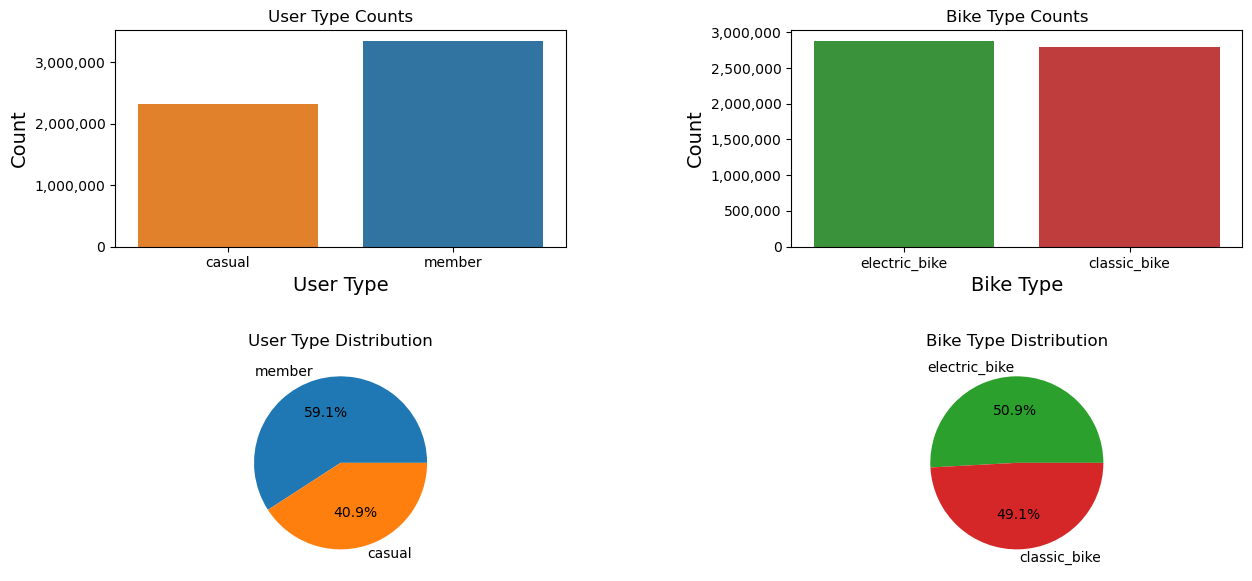

In [5]:
#Visualize user type and rideable type as pie charts and bar plots.

palette = {'member': '#1f77b4', 'casual': '#ff7f0e', 'electric_bike': '#2ca02c', 'classic_bike': '#d62728'}

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,6)) 
axs[0,0].ticklabel_format(style = 'plain')
axs[0,1].ticklabel_format(style = 'plain')
fig.tight_layout()
sns.countplot(data=combined_df, x='member_casual',ax=axs[0,0],palette=palette)
sns.countplot(data=combined_df, x='rideable_type',ax=axs[0,1],palette=palette)
user_types = combined_df['member_casual'].value_counts()
axs[1,0].pie(user_types, labels = user_types.index, autopct='%1.1f%%',colors=[palette['member'],palette['casual']])
axs[1,0].set_title("User Type Distribution")

bike_types = combined_df['rideable_type'].value_counts()
axs[1,1].pie(bike_types, labels = bike_types.index, autopct='%1.1f%%',colors=[palette['electric_bike'],palette['classic_bike']])
axs[1,1].set_title("Bike Type Distribution")

#make the y-axis ticks more readable
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
axs[0,0].yaxis.set_major_formatter(formatter)
axs[0,1].yaxis.set_major_formatter(formatter)

axs[0,0].set_title("User Type Counts")
axs[0,0].set_xlabel('User Type', fontsize=14)
axs[0,1].set_title("Bike Type Counts")
axs[0,1].set_xlabel('Bike Type', fontsize=14)
for ax in axs[0]:
    ax.set_ylabel('Count',fontsize=14)
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

## Analysis

Working with Members and Casual riders data separately we create several trip distributions:


In [6]:
df_members=combined_df[combined_df['member_casual']=='member']

#day of the week distribution
df_members.set_index('day_of_week',drop=False,inplace=True)
df_members_dayofweek_dist_series=df_members['day_of_week'].value_counts().sort_index()

#month distribution
df_members.set_index('started_at',drop=False,inplace=True)
df_members_month_dist_series=df_members.groupby(pd.Grouper(freq='M')).size()

#time of day distribution
df_members['started_at_time']=df_members['started_at'].dt.time
df_members['started_at_time']=pd.to_datetime(df_members['started_at_time'],format='%H:%M:%S', errors='coerce')
df_members.set_index('started_at_time',drop=False,inplace=True)
df_members_hour_dist_series=df_members.groupby(pd.Grouper(freq='30Min')).size()
df_members=df_members.reset_index(drop=True)

del df_members

In [7]:
df_casuals=combined_df[combined_df['member_casual']=='casual']

#day of the week distribution
df_casuals.set_index('day_of_week',drop=False,inplace=True)
df_casuals_dayofweek_dist_series=df_casuals['day_of_week'].value_counts().sort_index()

#month distribution
df_casuals.set_index('started_at',drop=False,inplace=True)
df_casuals_month_dist_series=df_casuals.groupby(pd.Grouper(freq='M')).size()

#time of day distribution
df_casuals['started_at_time']=df_casuals['started_at'].dt.time
df_casuals['started_at_time']=pd.to_datetime(df_casuals['started_at_time'],format='%H:%M:%S', errors='coerce')
df_casuals.set_index('started_at_time',drop=False,inplace=True)
df_casuals_hour_dist_series=df_casuals.groupby(pd.Grouper(freq='30Min')).size()
df_casuals=df_casuals.reset_index(drop=True)

del df_casuals 

## Comparison of user type by main metrics

In [8]:
def report_iqr(df_column):
    q1=df_column.quantile(0.5)
    q3=df_column.quantile(0.95)
    return q1,q3
    #print (f'90% of data points lie between {q1.round("s")} and {q3.round("s")}')

### trip duration

In [9]:
q05_m,q95_m=report_iqr(combined_df[combined_df.member_casual=='member']['ride_duration'])
print (f'90% of members ride durations lie between {q05_m.round("s")} and {q95_m.round("s")}')
q05_c,q95_c=report_iqr(combined_df[combined_df.member_casual=='casual']['ride_duration'])
print (f'90% of casual users ride durations lie between {q05_c.round("s")} and {q95_c.round("s")}')

90% of members ride durations lie between 0 days 00:08:57 and 0 days 00:32:53
90% of casual users ride durations lie between 0 days 00:13:19 and 0 days 01:07:53


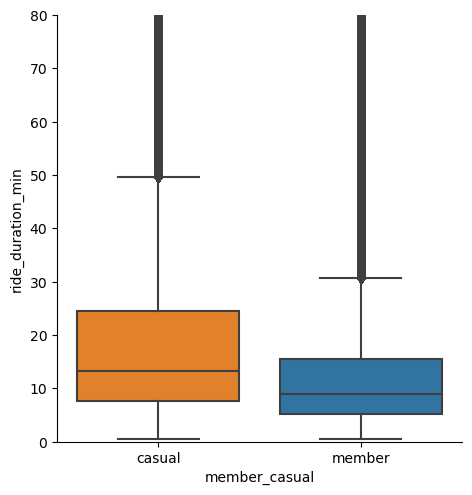

Mean casual user ride duration is 22.320412543197655 minutes
Mean member ride duration is 12.57567087082827 minutes

T-test indicates significant difference between users' and members' ride durations, p=0.0


In [10]:
combined_df['ride_duration_min'] = combined_df['ride_duration'].dt.total_seconds()/60
sns.catplot(data=combined_df,x='member_casual',y='ride_duration_min',kind='box',palette=palette)
plt.ylim([0,80])
plt.show()
print('Mean casual user ride duration is {} minutes'.format(combined_df.query('member_casual=="casual"')['ride_duration_min'].mean()))
print('Mean member ride duration is {} minutes'.format(combined_df.query('member_casual=="member"')['ride_duration_min'].mean()))

statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['ride_duration_min'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['ride_duration_min'].dropna())


if p<0.05:
    print (f"\nT-test indicates significant difference between users' and members' ride durations, p={p}")

### trip duration

In [11]:
q05_m,q95_m=report_iqr(combined_df[combined_df.member_casual=='member']['distance'])
print (f'90% of members ride distances lie between {q05_m} and {q95_m}')
q05_c,q95_c=report_iqr(combined_df[combined_df.member_casual=='casual']['distance'])
print (f'90% of casual users ride distances lie between {q05_c} and {q95_c}')

90% of members ride distances lie between 0.95 and 3.67
90% of casual users ride distances lie between 1.05 and 3.74


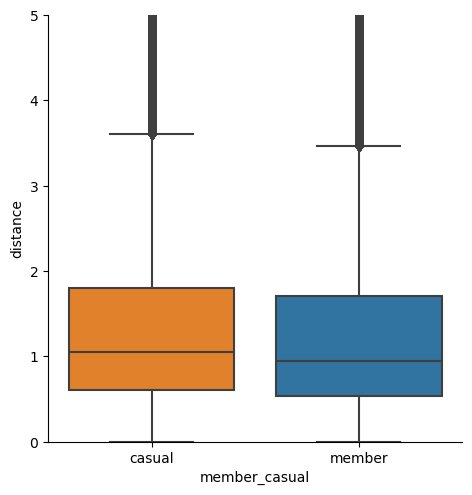

Mean casual user ride distance is 1.3758118135881334 miles
Mean member ride duration is 1.3149666327625062 miles

T-test indicates significant difference between users' and members' ride distances, p=0.0


In [12]:
sns.catplot(data=combined_df,x='member_casual',y='distance',kind='box',palette=palette)
plt.ylim([0,5])
plt.show()
statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['distance'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['distance'].dropna())
print('Mean casual user ride distance is {} miles'.format(combined_df.query('member_casual=="casual"')['distance'].mean()))
print('Mean member ride duration is {} miles'.format(combined_df.query('member_casual=="member"')['distance'].mean()))

if p<0.05:
    print (f"\nT-test indicates significant difference between users' and members' ride distances, p={p}")

the IQR of distances looks very similar despite a significant t-test. 
Lets exclude the top 5% of ride distances and compare again.

In [37]:
dist_m=combined_df[(combined_df['member_casual']=='member') & (combined_df['distance']>0)&(combined_df['distance']<q95_m)]['distance']
dist_c=combined_df[(combined_df['member_casual']=='casual') & (combined_df['distance']>0)&(combined_df['distance']<q95_c)]['distance']
#print (dist_m,dist_c)
statistic,p=ttest_ind(dist_c,dist_m)
if p<0.05:
    print (f"\nT-test indicates significant difference between users' and members' ride distances, p={p}, even with top 5% excluded")


T-test indicates significant difference between users' and members' ride distances, p=0.0, even with top 5% excluded


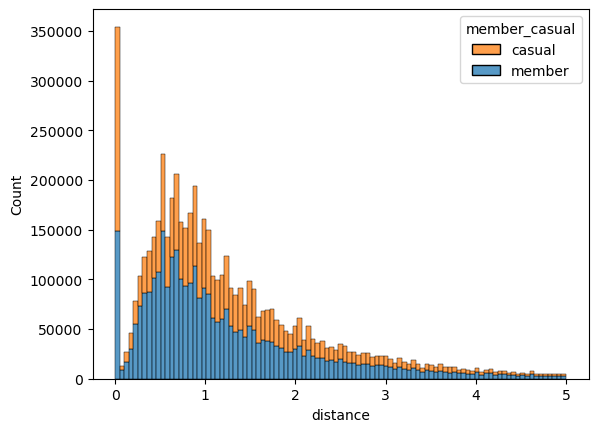

In [42]:
bins = np.linspace(0, 5, 100)
sns.histplot(data=combined_df,x='distance',hue='member_casual',multiple='stack',bins=bins,palette=palette)
plt.show()

### trip speed

In [47]:
q05_m,q95_m=report_iqr(combined_df[combined_df.member_casual=='member']['speed'])
print (f'90% of members ride speeds lie between {q05_m} and {q95_m}')
q05_c,q95_c=report_iqr(combined_df[combined_df.member_casual=='casual']['speed'])
print (f'90% of casual users ride speed lie between {q05_c} and {q95_c}')

90% of members ride speeds lie between 7.07 and 12.08
90% of casual users ride speed lie between 5.73 and 11.26


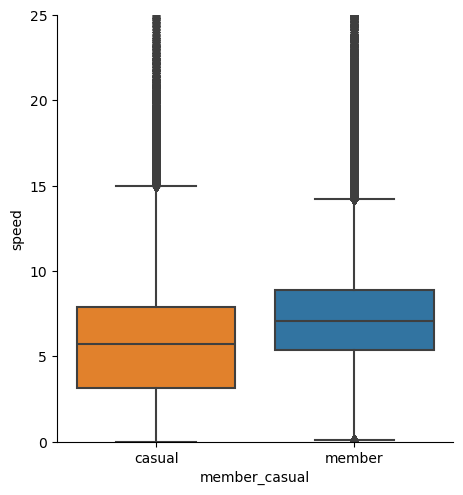

Mean casual user ride speed is 5.6087129236716695 mph
Mean member ride speed is 7.059180038843264 mph

T-test indicates significant difference between users' and members' ride distances, p=0.0


In [48]:
sns.catplot(data=combined_df,x='member_casual',y='speed',kind='box',palette=palette)
plt.ylim([0,25])
plt.show()
statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['speed'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['speed'].dropna())
print('Mean casual user ride speed is {} mph'.format(combined_df.query('member_casual=="casual"')['speed'].mean()))
print('Mean member ride speed is {} mph'.format(combined_df.query('member_casual=="member"')['speed'].mean()))

if p<0.05:
    print (f"\nT-test indicates significant difference between users' and members' ride distances, p={p}")

"g = sns.displot(\n    data=combined_df, x='speed',\n    bins=bins,hue='member_casual',multiple='stack',palette=palette,\n    facet_kws=dict(sharey=False, sharex=False)\n)\n\ndef specs(x, **kwargs):\n    plt.axvline(x.mean(), c='k', ls='-', lw=2.5)\n    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)\n\ng.map(specs,'speed' )"

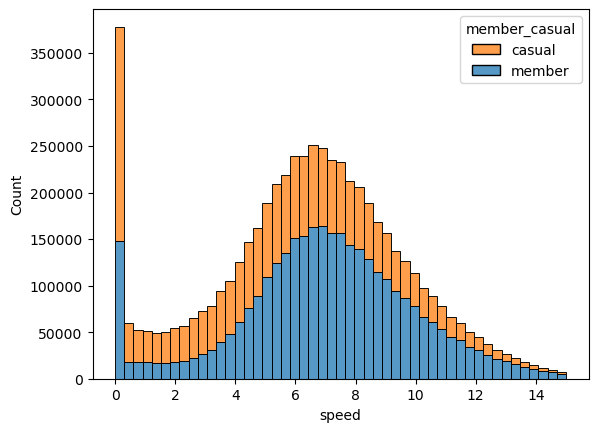

In [54]:
bins = np.linspace(0, 15, 50)
sns.histplot(data=combined_df,x='speed',bins=bins, hue='member_casual',multiple='stack',palette=palette)
'''g = sns.displot(
    data=combined_df, x='speed',
    bins=bins,hue='member_casual',multiple='stack',palette=palette,
    facet_kws=dict(sharey=False, sharex=False)
)

def specs(x, **kwargs):
    plt.axvline(x.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)

g.map(specs,'speed' )'''

In [45]:
statistic,p=ttest_ind(combined_df[combined_df['member_casual']=='member']['speed'].dropna(),
                     combined_df[combined_df['member_casual']=='casual']['speed'].dropna())
#print(statistic,p)
print('Mean casual user ride speed is {} mph'.format(combined_df.query('member_casual=="casual"')['speed'].mean()))
print('Mean member ride speed is {} mph'.format(combined_df.query('member_casual=="member"')['speed'].mean()))

if p<0.05:
    print ("T-test indicates significant difference between users' and members' average ride speeds")

Mean casual user ride speed is 5.6087129236716695 mph
Mean member ride speed is 7.059180038843264 mph
T-test indicates significant difference between users' and members' average ride speeds


### Bike usage by day of the week

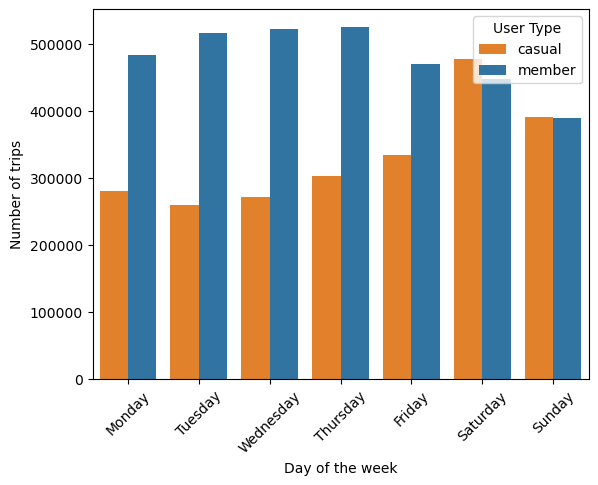

In [15]:
# Assuming df_casuals_dayofweek_dist_series and df_members_dayofweek_dist_series are pandas Series
# with the counts of 'Casuals' and 'Members' for each day of the week, respectively
X = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
X_axis = np.arange(len(X))

df_casuals = df_casuals_dayofweek_dist_series.reset_index()
df_members = df_members_dayofweek_dist_series.reset_index()

# Rename the columns
df_casuals.columns = ['Day of the week', 'Number of trips']
df_members.columns = ['Day of the week', 'Number of trips']

# Add a new column for the type of user
df_casuals['User Type'] = 'casual'
df_members['User Type'] = 'member'
df = pd.concat([df_casuals, df_members])

# Create the bar plot
sns.barplot(x='Day of the week', y='Number of trips', hue='User Type', data=df,palette=palette)

plt.xticks(X_axis, X, rotation=45)
plt.show()


In [16]:
statistic,p=mannwhitneyu(df_casuals_dayofweek_dist_series,df_members_dayofweek_dist_series)
if p<0.05:
    print ("Mann-Whitney test shows that the time of day distributions are different for members and casual users(p={})".format(round(p,2)))

Mann-Whitney test shows that the time of day distributions are different for members and casual users(p=0.01)


### Bike usage by month

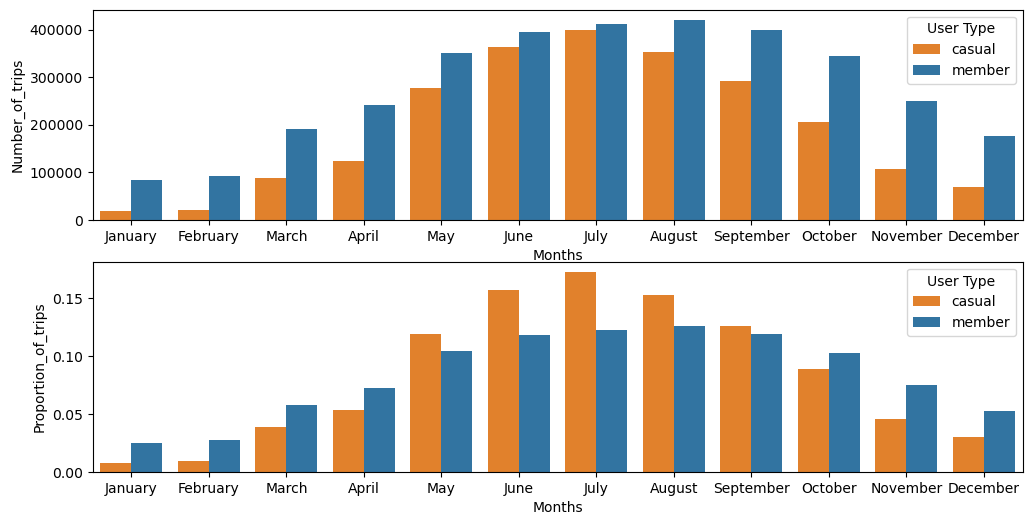

In [17]:
X = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
X_axis = np.arange(len(X))

df_casuals = df_casuals_month_dist_series.reset_index()
df_members = df_members_month_dist_series.reset_index()

# Rename the columns
df_casuals.columns = ['Months', 'Number_of_trips']
df_members.columns = ['Months', 'Number_of_trips']
df_casuals['Proportion_of_trips']=df_casuals['Number_of_trips'] / df_casuals['Number_of_trips'].sum()
df_members['Proportion_of_trips']=df_members['Number_of_trips'] / df_members['Number_of_trips'].sum()
# Add a new column for the type of user
df_casuals['User Type'] = 'casual'
df_members['User Type'] = 'member'
df = pd.concat([df_casuals, df_members])


df['Months'] = pd.to_datetime(df['Months']).dt.month_name()
# Create the bar plot
fig, axs = plt.subplots(nrows=2, figsize=(12,6)) 
sns.barplot(x='Months', y='Number_of_trips', hue='User Type', data=df,order=X,ax=axs[0],palette=palette)
sns.barplot(x='Months', y='Proportion_of_trips', hue='User Type', data=df,order=X,ax=axs[1],palette=palette)
plt.setp(axs, xticks=X_axis)
plt.show()



In [18]:
statistic,p=mannwhitneyu(df_casuals_month_dist_series.dropna(),df_members_month_dist_series.dropna())
if p<0.05:
    print ("Mann-Whitney test shows that month distributions are different for members and casual users(p={})".format(round(p,2)))
else:
    print ("Mann-Whitney test shows no difference in month of use distributions between members and casual users(p={})".format(round(p,2)))

Mann-Whitney test shows no difference in month of use distributions between members and casual users(p=0.16)


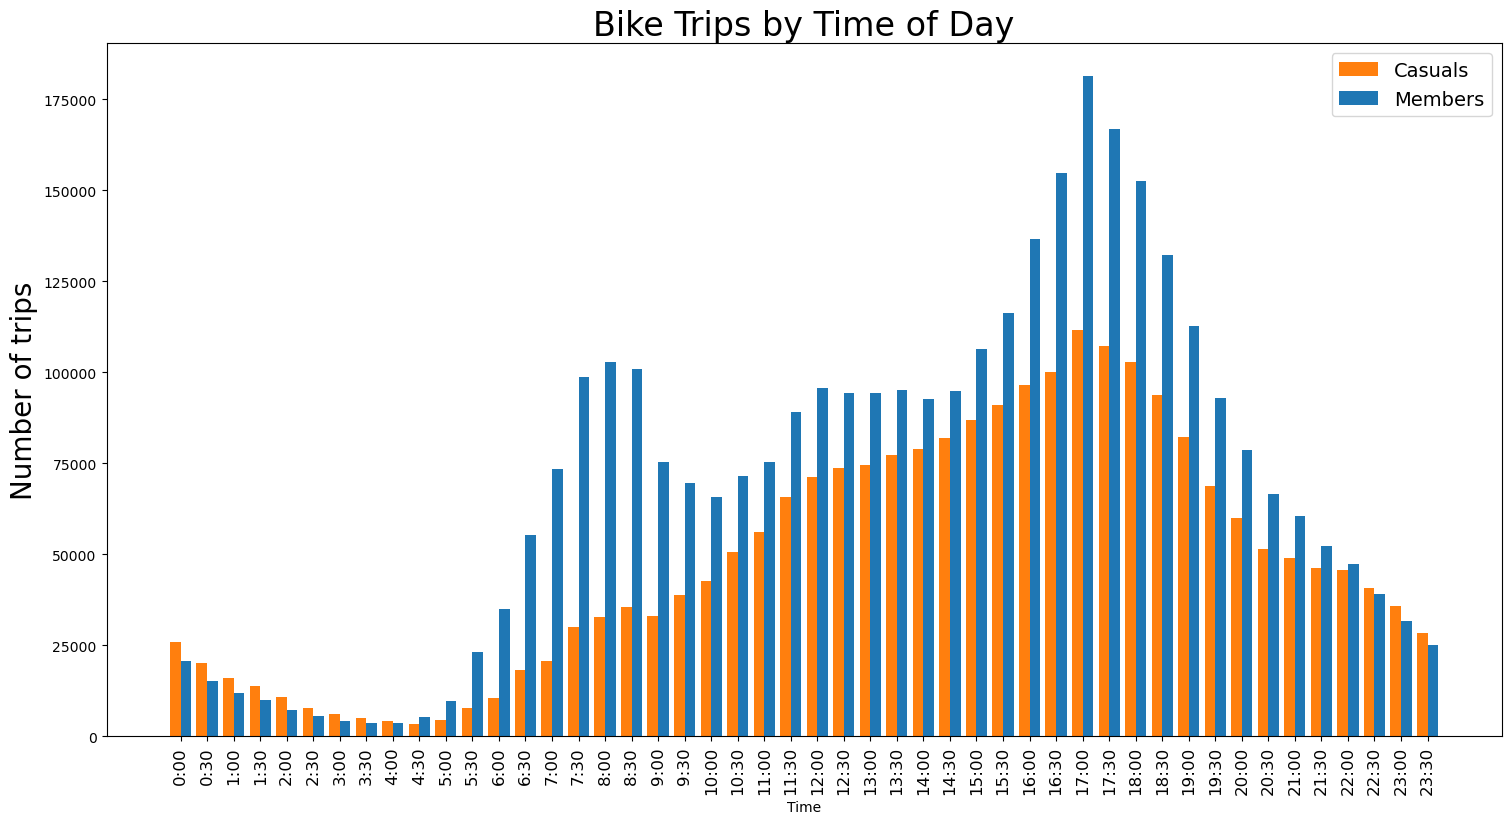

In [19]:
#create time intervals for time of day analyses.
H=[hours for hours in range(24)]
M=['00',30]
X=[(str(h)+':'+str(m)) for h in H for m in M]

f,ax=plt.subplots(figsize=(18,9))

X_axis=np.arange(len(X))
plt.bar(X_axis - 0.2, df_casuals_hour_dist_series, 0.4, label = 'Casuals',color=palette['casual'])
plt.bar(X_axis + 0.2, df_members_hour_dist_series, 0.4, label = 'Members',color=palette['member'])
plt.xticks(X_axis, X, rotation=90,fontsize=12)
plt.xlabel("Time")
plt.ylabel("Number of trips",fontsize=20)
plt.title("Bike Trips by Time of Day",fontsize=24)
ax.legend(fontsize=14)


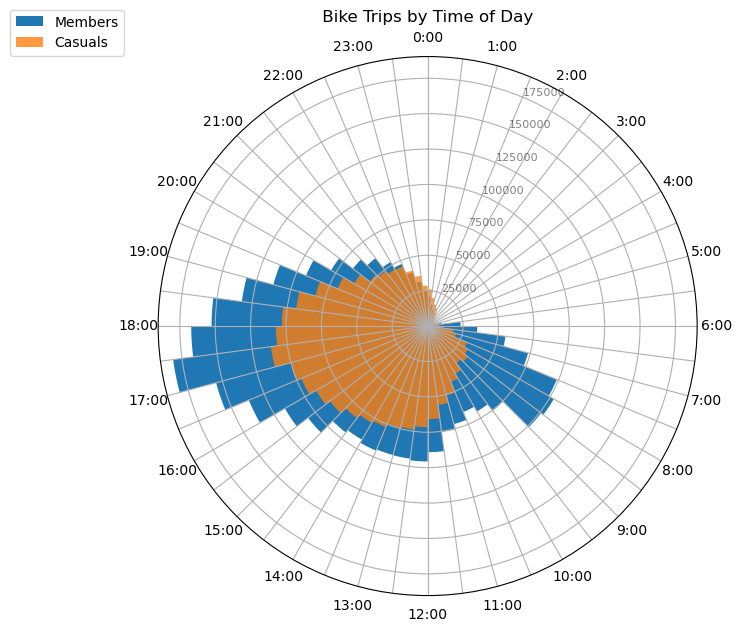

In [22]:
df_times = pd.DataFrame({'Members': df_members_hour_dist_series, 'Casuals': df_casuals_hour_dist_series})

X_padded=[X[i] if i%2==0 else '' for i,_ in enumerate(X)]
X_padded

def render_chart(df, axis, title):
    theta = np.arange(df.shape[0])/float(df.shape[0]) * 2 * np.pi
    _ = axis.bar(theta + theta[1]/2, df.Members, width=theta[1], label='Members',color=palette['member'])
    _ = axis.bar(theta + theta[1]/2, df.Casuals, width=theta[1], alpha=0.8,label='Casuals',color=palette['casual'])
    #ticklabels = [(timedelta(hours=h) + datetime(2021,1,1)).strftime('%#I%p').lower() for h in range(0,48)]
    ticklabels=X_padded
    _ = axis.set_xticks(theta)
    _ = axis.set_xticklabels(ticklabels,fontsize=10)
    #_ = axis.set_yticklabels(['']) #for empty ticklabels
    #_ = axis.set_yticklabels (alpha=0.5)
    _ = axis.tick_params(axis='y', labelsize=8, labelcolor=(0, 0, 0, 0.5)) 
    _ = axis.set_title(title)
    _ = axis.legend(loc='best',bbox_to_anchor=(-0.05, 1.1, 0, 0))
    axis.set_theta_direction(-1)
    axis.set_theta_zero_location('N')

fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={'projection': 'polar'})
 
render_chart(df_times, ax, 'Bike Trips by Time of Day')

In [21]:
statistic,p=mannwhitneyu(df_casuals_hour_dist_series,df_members_hour_dist_series)
if p<0.05:
    print ("Mann-Whitney test shows that the time of day distributions are different for members and casual users(p={})".format(round(p,2)))

Mann-Whitney test shows that the time of day distributions are different for members and casual users(p=0.03)


## Analysis interpretation

With no clear difference between members and casual users in terms of trip duration or distance, we are still able to focus on key distinctions in bike usage patterns:

1. **Weekly Preferences**: Casual users strongly prefer weekends for the trips compared to paying members as evidenced by a statistically significant Mann-Whitney test result. This trend could suggest that casual users are more likely to use the service for leisure or recreational activities. Seasonal preference does not appear to be significantly different between members and casual users.
2. **Commuting Patterns**: Paying members show much stronged weekday usage as well as continued usage trough winter months, likely indicating commuting behavior.
3. **Time-of-Day Usage**: Paying members show a typical morning commute pattern, suggesting that they use the service to travel to work or school. On the other hand, casual users do not exhibit this pattern, further supporting the idea that their usage is more likely driven by leisure or recreational activities.


## Putting the data to use

Based on my comprehensive analysis of user trips, we propose the following strategic actions:
1. **Marketing Strategy**: Intensify marketing efforts highlighting the benefits of membership, specifically targeting visitors during the summer months in Chicago for maximum reach. This could include special promotions or discounts for first-time users. 
2. **Partnerships**: Collaborate with local events, such as festivals or concerts, that attract tourists. This could involve offering special promotions or setting up temporary bike stations near the event locations.
3. **Flexible Subscription Models:**: Introduce a weekly subscription model catering to visitors who may not be staying for multiple months but would still benefit from a short-term subscription.

By strategically targeting these specific groups of tourists and offering flexible subscription options, I believe that Divvy Bikeshare can effectively convert more casual users into paid members, thereby increasing overall revenue and user satisfaction.


